# Statistical Modelling and Inference Project Assignment

## by Sebastian Wolf

In [1]:
# Loading necessary modules

%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.datasets as ds
import pandas as pd
import sklearn.linear_model as lm
import scipy
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

# 0 Motivation

In this project I will study the link function of generalized linear models. In particular I will focus on binary regression. In most cases binary regression is estimated using the canonical link, the logit function, that arises naturally from the Bernoulli distribution. The results are generally thought to be similar to the results other link functions would deliver. In this project I am interested in their differences.

To study the differences, I take the following steps:
- Discuss the theory behind generalized linear models to understand which role the link function plays
- Set up an estimation function which gives me control over the link function, and test it on a toy dataset
- Set up a synthetic dataset which allows me to explore how outliers or class imbalance affect predictive performance using the different link functions
- Explain results - I do this throughout the notebook and in a conclusion


# 1 Introduction

## 1.1 Linear Models

Linear models relate an output variable to a linear combination of features, where features are functions of input variables. 

$ E[y\ |\textbf{x}]=\beta^T \phi(\textbf{x})$

In what follows I will denote $\phi(\textbf{x})$ with $ \phi $ to lighten the presentation.

Features can be non-linear functions of the input variables, so linear models are able to capture a non-linear relationship between input variables and output variables while maintaining the desirable analytical features of linearity in parameters. The standard linear model relates the conditional mean of the output variable to the features linearly, and assumes that errors are independent gaussian noise around this mean. 

However, in many real-world situations the output variable is not defined on the whole real number line, and in these situations it is inappropriate to model its conditional mean as a linear combination of features that are defined on the whole real number line. If we did, the model could perceivably produce predicitions that fall outside of the range the output variable is defined on.

When $y \in \{0,1\}$, we can ***not*** model $ E[y\ |\ \textbf{x}]=p(y=1|\ \textbf{x}) =\beta^T \phi$

I plot this unsuitable model as example 1 below. The blue line represents the linear relationship fitted by a linear model that relates the conditional mean linearly to the features. We can see that for x > 5 the model predicts output values larger than 1, which is outside of the set that the output was defined on.

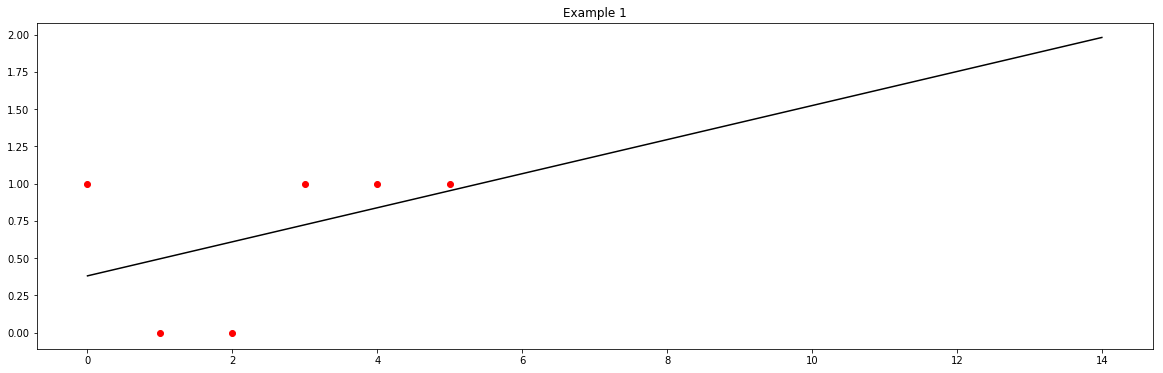

In [2]:
###### Plotting example 1 - Why simple linear regression is inappropriate for binary classification

y = np.array([1,0,0,1,1,1])
x = np.arange(6).reshape(-1,1)

# Create linear regression object
regr = lm.LinearRegression()

regr.fit(x,y)

x_pred = np.arange(15).reshape(-1,1)
y_pred = regr.predict(x_pred)

# Plot outputs

plt.figure(figsize=(20, 6))
plt.scatter(x, y,  color='red')
plt.plot(x_pred, y_pred, 'black')
plt.title('Example 1')
plt.show()

## 1.2 Generalized Linear Models

To overcome the mapping incompatibilities but maintain linearity in parameters, we can employ generalized linear models. Generalized linear models use a link function that maps the conditional mean of the output to a linear combination of the features, and thus have much wider applicability than the simple linear regression model, which  invariably relies on a linear link. 

#### Link function: $g(E[y\ |\textbf{x}])=\beta^T \phi$

Furthermore, the distribution of errors around the conditional mean in generalized linear models need not be Gaussian - any distribution from the exponential family can be chosen to fit the phenomenon to be modelled. In some cases, this choice is very straightforward and unequivocal, for example when we are modelling a binary outcome, as in the example above. In this case the only plausible distribution is the Bernoulli distribution.

When $y \in \{0,1\}$ the choice of the distribution of our error is unequivocal: 

#### Distribution of binary output: $y| \ x \sim Bernoulli(\mu) \implies p(y| \ x)=\mu^y (1-\mu)^{1-y}$

We can write this in the form of the exponential family:

#### Bernoulli as part of exponential family: $p(y| \ x)= e^{y \ ln{(\mu)}\  +\  (1-y) \ ln{(1-\mu)}} = e^{y \ ln{(\frac{\mu}{1-\mu})}\  + \ ln{(1-\mu)}} = e^{y \ \theta - ln(1+e^{\theta})} \ $   where  $\ \theta = ln{(\frac{\mu}{1-\mu})}$

Members of the exponential family each have a canonical link function that links the conditional mean of the distribution with the linear parameters. We can compute the conditional mean of the above by taking the derivative of the log-partition with respect to the normal parameter $\theta$:

#### Deriving expected value of Bernoulli in exponential form: $E[y| \ x]= \frac{\partial}{\partial \theta} c(\theta) =  \frac{\partial}{\partial \theta} ln(1+e^{\theta}) = \frac{e^{\theta}}{1+e^{\theta}} = \mu \ $ 

when we invert this we get back $\theta = ln(\frac{\mu}{1-\mu}) \ $ 

This demonstrates that the logistic function is the naturally arising, canonical link function for the Bernoulli distribution, mapping the expected value to the linear parameters.

#### Canonical link: $ g(E[y\ |\textbf{x}])= ln(\frac{E[y|\textbf{x}]}{1-E[y|\textbf{x}]})= \beta^T \phi$

#### Inverse of canonical link: $E[y|\textbf{x}] = g^{-1}(\beta^T \phi) = \frac{1}{1+e^{-\beta^T \phi}}$

A main benefit of the framework of generalized linear models is that its negative log-likelihood is convex in many cases, such that we can use gradient-based convex optimization alogrithms to solve for the parameters that maximise the likelihood of a particular sample. To show this in the case of the Bernoulli distribution, we take the negative log-likelihood and compute the Hessian:

#### Negative Bernoulli log-likelihood: $ - n \sum_{i=1}^{n} ln(p(y_{i}| \ x_{i}))= - \sum_{i=1}^{n} y_{i} \ \theta - ln(1+e^{\theta}) \ = - \sum_{i=1}^{n} y_{i} \beta^T \phi_{i} - ln(1+e^{\beta^T \phi_{i}}) \ $

#### Score wrt $\beta$: $ - \sum_{i=1}^{n}  \phi_{i}  (y_{i}- \frac{1}{1+e^{- \beta^T \phi_{i}}}) =  $

#### Hessian wrt $\beta$: $ - \sum_{i=1}^{n}  \phi_{i}   \phi_{i}^{T} \frac{1}{1+e^{- \beta^T \phi_{i}}} (1-\frac{1}{1+e^{- \beta^T \phi_{i}}})$

It is easily seen that this sum is positive, and the problem therefore amenable to convex optimisation.

## 1.3 Link functions

Even though the Bernoulli function naturally gives rise to the logit link, this is by far not the only possible link function we can use. In fact, any CDF fulfills that purpose, because it maps the real number line to the interval between 0 and 1.

In this project I will look at the three most commonly used: **the logit, the probit and the cauchy link functions**. I begin by plotting them below, and in the code I show their inverses. They all have similar shapes, but three important attributes in which they differ are their center, the thickness of their tails (kurtosis), and the steepness around the mean. All these attributes are likely to have effect on our estimation results, and in this project I will try to tease out a few of them.

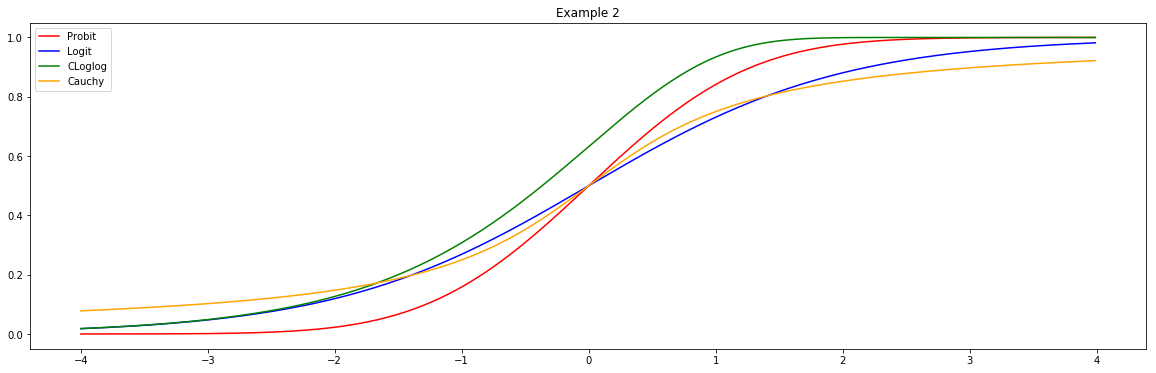

In [3]:
###### Plotting example 2 - How do the different CDFs/ Link functions compare?

# Create grid
dx = 0.01
X_example  = np.arange(-4, 4, dx)

# Compute the CDFs
Probit  = scipy.special.ndtr(X_example)
Logit   = 1 / (1 + np.exp(-X_example))
CLoglog = 1 - np.exp(- np.exp(X_example))
Cauchy  = 1 / math.pi * np.arctan(X_example) + 0.5

# Plot the three curves
labels = ['Probit','Logit','CLoglog', 'Cauchy']
plt.figure(figsize=(20, 6))
plt.plot(X_example, Probit, 'r')
plt.plot(X_example, Logit, 'b')
plt.plot(X_example, CLoglog, 'g')
plt.plot(X_example, Cauchy, 'orange')
plt.title('Example 2')
plt.legend(labels)
plt.show()

# 2 Analysis

## 2.1 Toy dataset

In this sub-section, I test the regression functions and the ROC function on a toy dataset to establish their validity and to build a comparator case for the later more in-depth study of the behavior of the link function using a synthetic dataset.

In [4]:
###### Loading the breast cancer dataset to test the regression functions

breast_cancer = ds.load_breast_cancer()
# X = sklearn.preprocessing.StandardScaler(breast_cancer.data[:, :10]) # uncomment and comment next line for pre-processing
X = breast_cancer.data[:, :10]
X = sm.add_constant(X)
y = (breast_cancer.target != 0) * 1

In [5]:
# What is the class balance?
pd.DataFrame(y).mean()

0    0.627417
dtype: float64

Classes are relatively well balanced.

In [6]:
# How do our features look?
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Feature space differs significantly in distribution (mean, variance).

In [7]:
# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.5, random_state=1)

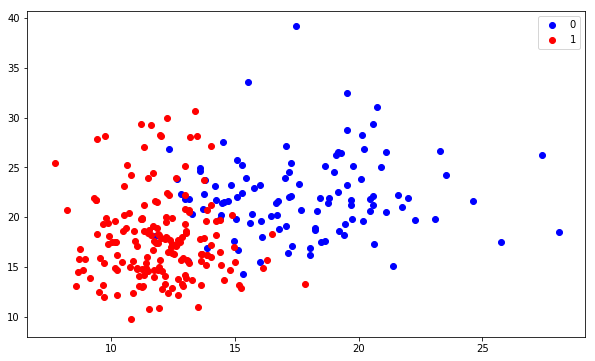

In [8]:
###### Visualise classes for two features of the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0][:, 1], X_train[y_train == 0][:, 2], color='b', label='0')
plt.scatter(X_train[y_train == 1][:, 1], X_train[y_train == 1][:, 2], color='r', label='1')
plt.legend();

This displays the class separation for the two first features. The training set displays very strong class separation - the problem seems relatively easy to classify, but since it is in the medical domain, accuracy could be of high importance.

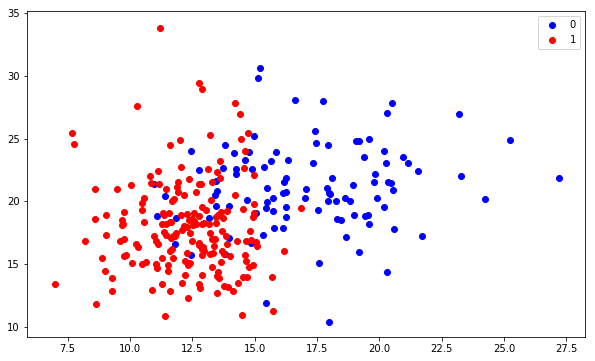

In [9]:
###### Visualise classes for two features of the test data
plt.figure(figsize=(10, 6))
plt.scatter(X_test[y_test == 0][:, 1], X_test[y_test == 0][:, 2], color='b', label='0')
plt.scatter(X_test[y_test == 1][:, 1], X_test[y_test == 1][:, 2], color='r', label='1')
plt.legend();

The test set looks very similar to the training set, which gives me confidence that the division between test and training sets worked properly.

In [10]:
###### This function requires a list of link functions, and estimates a generalized linear model using the link
###### function provided. It returns regression summaries, a list of regression result objects, and a list of names.

def estimate(linkf = ['logit', 'probit']):
    model_summaries = []
    models = []
    model_names = []
    for i in linkf:
        if i == 'logit':
            link = sm.genmod.families.links.logit
            link = sm.genmod.families.family.Binomial(link)
            logit_model = sm.GLM(y_train,X_train,link).fit(maxiter = 1000)
            models.append(logit_model)
            model_summaries.append(logit_model.summary())
            model_names.append(i)
        elif i == 'probit':
            link = sm.genmod.families.links.probit
            link = sm.genmod.families.family.Binomial(link)
            probit_model = sm.GLM(y_train,X_train,link).fit(maxiter = 1000)
            models.append(probit_model)
            model_summaries.append(probit_model.summary())
            model_names.append(i)
        elif i == 'cloglog':
            link = sm.genmod.families.links.cloglog
            link = sm.genmod.families.family.Binomial(link)
            cloglog_model = sm.GLM(y_train,X_train,link).fit(maxiter = 1000)
            models.append(cloglog_model)
            model_summaries.append(cloglog_model.summary())
            model_names.append(i)
        elif i == 'cauchy':
            link = sm.genmod.families.links.cauchy
            link = sm.genmod.families.family.Binomial(link)
            cauchy_model = sm.GLM(y_train,X_train,link).fit(maxiter = 1000)
            models.append(cauchy_model)
            model_summaries.append(cauchy_model.summary())
            model_names.append(i)
    return model_summaries, models, model_names

I compute the regression summaries for the toy dataset using the **probit** and **logit** link function via the GLM regressiomn from the statsmodels package. I also tried the **cloglog** and the **cauchy link** link functions, but get an error to do with division by zero, which I assume relates to their functional form.

To understand the errors would require dissecting the statsmodel package, which I did not have time for. I also tried building my own algorithm, but it also failed with these functions. I showcase this in the Appendix.

In [11]:
estimate()

([<class 'statsmodels.iolib.summary.Summary'>
  """
                   Generalized Linear Model Regression Results                  
  Dep. Variable:                      y   No. Observations:                  284
  Model:                            GLM   Df Residuals:                      273
  Model Family:                Binomial   Df Model:                           10
  Link Function:                  logit   Scale:                          1.0000
  Method:                          IRLS   Log-Likelihood:                -31.643
  Date:                Mon, 03 Dec 2018   Deviance:                       63.287
  Time:                        03:29:22   Pearson chi2:                     380.
  No. Iterations:                     9   Covariance Type:             nonrobust
                   coef    std err          z      P>|z|      [0.025      0.975]
  ------------------------------------------------------------------------------
  const         43.5951     25.868      1.685      0.092 

The outputs for the logit and probit GLM regressions show similar deviance, and log-likelihood, with the logit model performing slighly bettter. Both models identify variable x2 as the most significant predictor, the rest of the variables are not statistically signifanctly different from zero; x8 and x9 come close in both models. To improve the model, a variable selection procedure would be required.

How do these results translate into performance in terms of prediction?

In [12]:
###### This function will be at the heart of our analysis - the ROC curve and the AUC statistic

def plot_roc(color, 
             y_test = y_test, 
             models = estimate()[1], 
             model_names = estimate()[2], 
             zoomx = 1.0,
             zoomy = 0,
             zoom_x = 0,
             zoom_y = 1.0,
             title = 'Receiver operating characteristic'):
    
    plt.figure(figsize=(10,10))
    lw = 2
    
    for m, c, n in zip(models,color,model_names):
        
        fpr, tpr, _ = roc_curve(y_test, m.predict(X_test))
        roc_auc = auc(fpr, tpr)   
    
        plt.plot(fpr, tpr, color=c, lw=lw, label='ROC curve ' + n + ' (area = %0.6f)' % roc_auc,)
        
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
    plt.xlim([zoom_x, zoomx])
    plt.ylim([zoomy, zoom_y])
    plt.xlabel('False Positive Rate' , fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title(title , fontsize=20)
    plt.legend(loc="lower right", fontsize=15)
    plt.show()

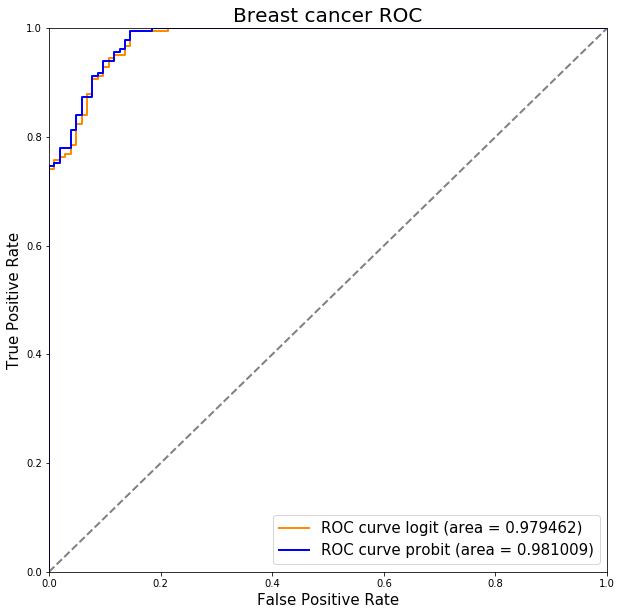

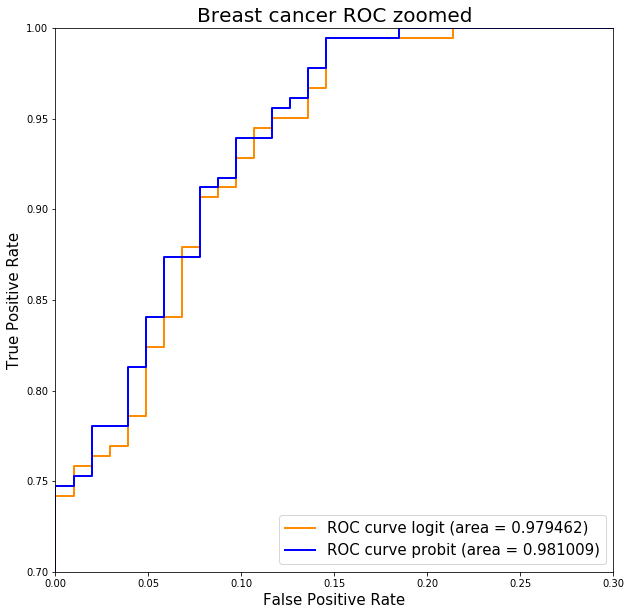

In [13]:
plot_roc(title = 'Breast cancer ROC', color = ['darkorange','blue'])
plot_roc(zoomx = 0.3, zoomy = 0.7, title = 'Breast cancer ROC zoomed', color = ['darkorange','blue'])

### 2.1.2 Takeaways from the toy dataset

- The cauchy and cloglog models could not be computed. This raises the question whether they render estimation procedures less robust? The features make up a positive exponent in the inverse link of the cloglog case, which suggests that this function is sensitive to outliers and high absolute values; this might be a reason for its failure here.
- In terms of estimation, probit and logit links perform similar and predict the classes well, but is the predictive power sufficient for diagnosis? Also, note that I used symmetric loss in this case - this will probably not be appropriate in the medical domain.
- I would need to take into account oversampling of the positive class, on which I dont have information.
- This dataset shows the power of the classifier, even without model selection and proper pre-processing. But it is be difficult to isolate effects of different aspects of the data on the behavior of the link function - therefore I now move to study a synthetic dataset.

## 2.2 Studying the link function using synthetic data

I use the scikit-learn package to generate a classification dataset of two classes, and one cluster per class. I generate 10000 observations, which I split into test and training. The output is explained by 20 features, 10 of which are informative in the base case. I now vary a number of aspects of the dataset to study how they impact the precitive power of the GLM model with the **logit, probit and cauchy** link functions. First, however, I will study a well-behaved dataset.

## 2.2.1 First synthetic data set - well-behaved data

- 5000 training, 5000 test observations
- 20 features, 10 informative
- class separation factor = 1
- 2 % of labels flipped

In [14]:
# Generate the dataset
synthetic = sklearn.datasets.make_classification(n_samples=10000, n_features=20, n_informative=10,
                                                 n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                                                 weights=None, flip_y=0.02, class_sep=1.0, hypercube=True, shift=0.0,
                                                 scale=1.0, shuffle=False, random_state=1)

# Assign to arrays
X, y = synthetic[0], synthetic[1]

# Split into test and training
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.5, random_state=1)

In [15]:
# This produces the regression outputs as for the toy dataset, but for the sake of brevity I omit them.
# estimate(['logit', 'probit', 'cauchy'])

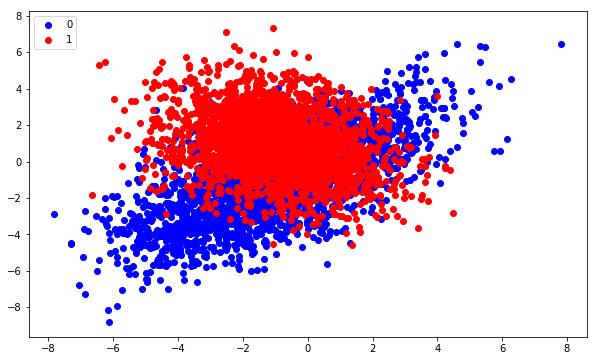

In [16]:
# Classes visualised for two features for the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0][:, 5], X_train[y_train == 0][:, 6], color='b', label='0')
plt.scatter(X_train[y_train == 1][:, 5], X_train[y_train == 1][:, 6], color='r', label='1')
plt.legend();

This plots the distriution of the two classes for two of the informative features. Class 1 (red) seems to be slightly positively related with the feature on the y-axis; for the x-axis it is difficult to tell. The plot exhibits an interesting covariance relationship, where the covariance of x-axis feature and y-axis feature conditional on class 1 is negative, and conditional on class 0 is positive. This suggests that the interaction of the features could improve the model, but model selection is not our focuse here. Each link function is given the same set of tools - a linear combination of features, that it is supposed to relate to the mean of the output. As such, I expect that the difference in response will likely show in the behavior in the face of outliers or class imbalance.

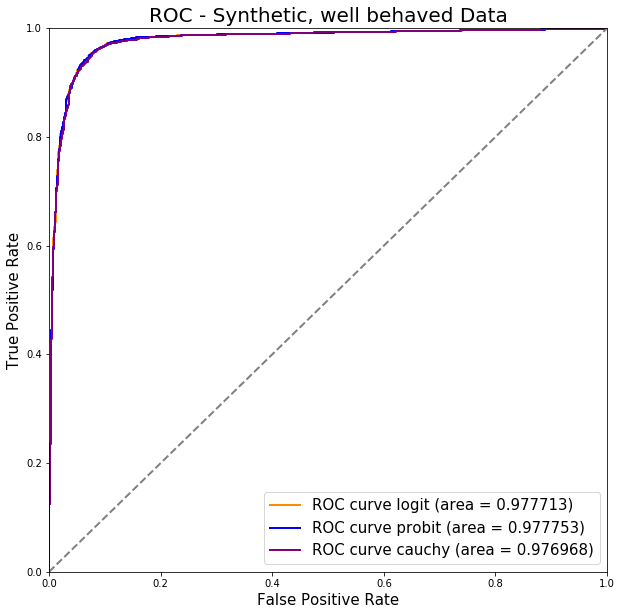

In [17]:
plot_roc(y_test = y_test, title = 'ROC - Synthetic, well behaved Data', color = ['darkorange','blue','purple'],
         models = estimate(linkf = ['logit','probit','cauchy'])[1], 
         model_names = estimate(linkf = ['logit','probit','cauchy'])[2])

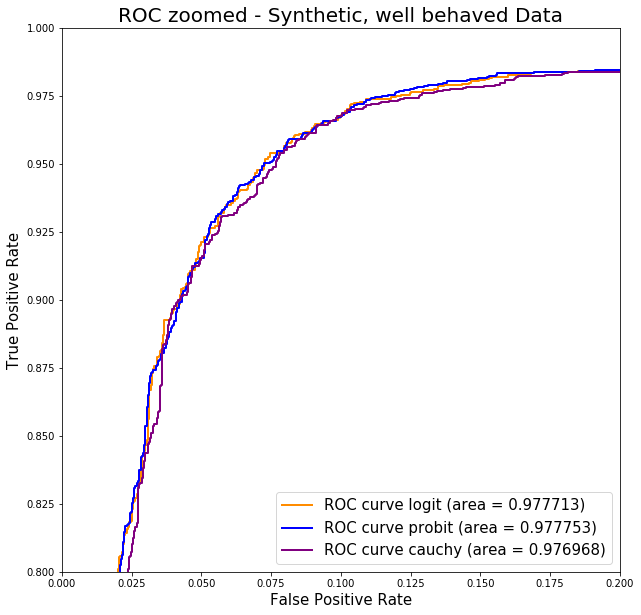

In [18]:
plot_roc(y_test = y_test, title = 'ROC zoomed - Synthetic, well behaved Data', color = ['darkorange','blue','purple'],
         models = estimate(linkf = ['logit','probit','cauchy'])[1], 
         model_names = estimate(linkf = ['logit','probit','cauchy'])[2], zoomx= 0.2, zoomy = 0.8)

### Key takeaways for well-behaved data

- The logit and probit link functions yield the best predicitions as measured by the area under the curve, but all are fairly similar
- As shown in Example 2 figure above, in its standard configuration the cauchy cdf is less steep around the mean and so assigns a lower range of probabilities to the area around the mean combination of features. This means that it can be expected to yield less accurate predictions for samples with lower variance.

I next study how the models react to flipped labels, or as I call them here, outliers.

## 2.2.2 Second synthetic data set  -  many outliers

- 5000 training, 5000 test
- 20 features, 10 informative
- classes separation = 1
- **50 % of labels flipped**

In [19]:
synthetic = sklearn.datasets.make_classification(n_samples=10000, n_features=20, n_informative=10,
                                                 n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                                                 weights=None, flip_y=0.5, class_sep=1.0, hypercube=True, shift=0.0,
                                                 scale=1.0, shuffle=False, random_state=1)

# Assign to arrays
X, y = synthetic[0], synthetic[1]

# Split into test and training
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.5, random_state=1)

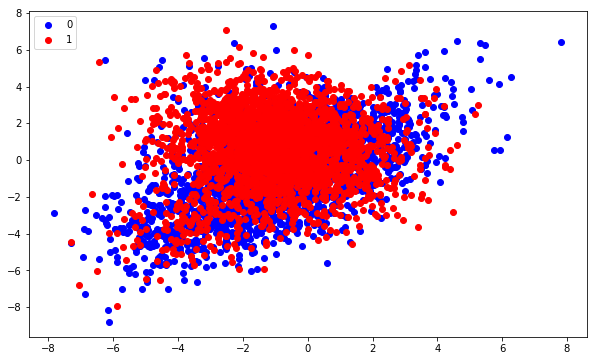

In [20]:
# Classes visualised for two features for the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0][:, 5], X_train[y_train == 0][:, 6], color='b', label='0')
plt.scatter(X_train[y_train == 1][:, 5], X_train[y_train == 1][:, 6], color='r', label='1')
plt.legend();

We can see that in this sample the two classes mesh together much more, because of the flipped labels. The original data before flipping is the same.

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [22]:
# estimate(['logit', 'probit', 'cauchy'])

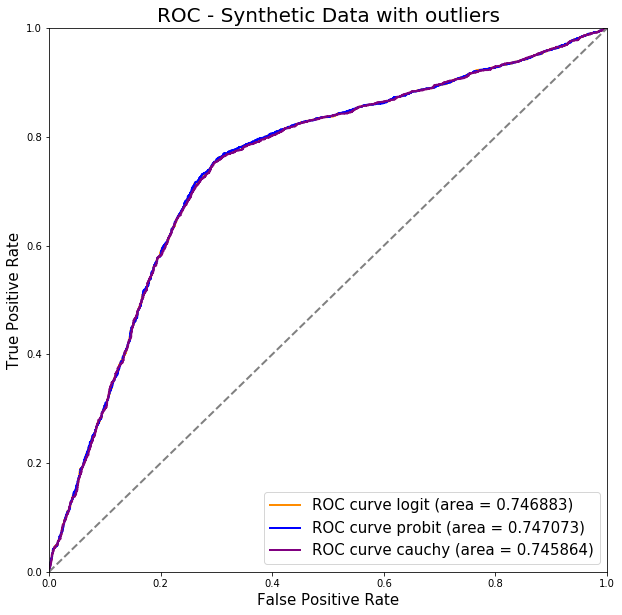

In [23]:
plot_roc(y_test = y_test, title = 'ROC - Synthetic Data with outliers', color = ['darkorange','blue','purple'],
         models = estimate(linkf = ['logit','probit','cauchy'])[1], 
         model_names = estimate(linkf = ['logit','probit','cauchy'])[2])

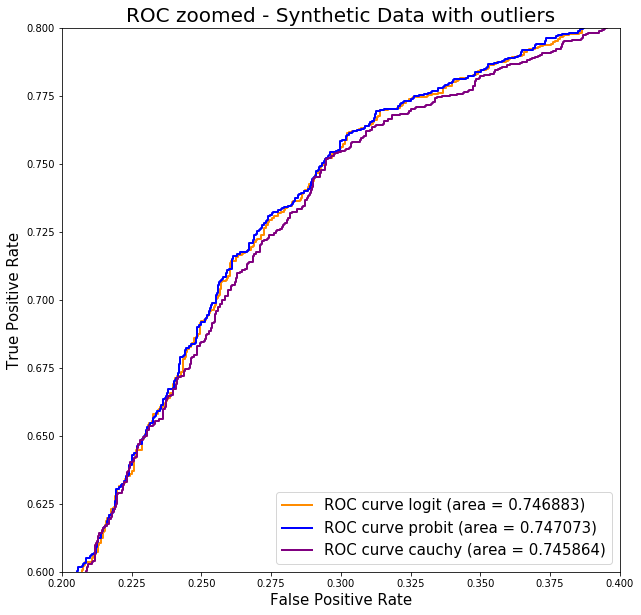

In [24]:
plot_roc(y_test = y_test, title = 'ROC zoomed - Synthetic Data with outliers', color = ['darkorange','blue','purple'],
         models = estimate(linkf = ['logit','probit','cauchy'])[1], 
         model_names = estimate(linkf = ['logit','probit','cauchy'])[2], zoomx= 0.4, zoom_x = 0.2, zoom_y = 0.8 ,zoomy = 0.6)

### Key takeaways for data with outliers

- Performance deteriorates uniformly with outliers
- All curves become more pointed, as classes are still well balanced and separated, but 'noise' from the flipped labels increases.
- It is possible that differences in response were muted as outliers were not very extreme.

## 2.2.3 Third synthetic data set - class imbalance

- 5000 training, 5000 test
- 20 features, 10 informative
- classes separation = 1
- 2 % of labels flipped
- **severe class imbalance: 0.99 to 0.01**

In [25]:
synthetic = sklearn.datasets.make_classification(n_samples=100000, n_features=20, n_informative=10,
                                                 n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                                                 weights=[0.99,0.01], flip_y=0.02, class_sep=1.0, hypercube=True, 
                                                 shift=0.0, scale=1.0, shuffle=False, random_state=1)

# Assign to arrays
X, y = synthetic[0], synthetic[1]

# Split into test and training
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.5, random_state=1)

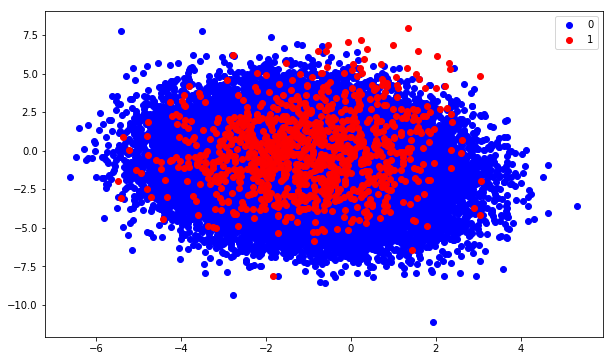

In [26]:
# Classes visualised for two features for the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0][:, 5], X_train[y_train == 0][:, 6], color='b', label='0')
plt.scatter(X_train[y_train == 1][:, 5], X_train[y_train == 1][:, 6], color='r', label='1')
plt.legend();

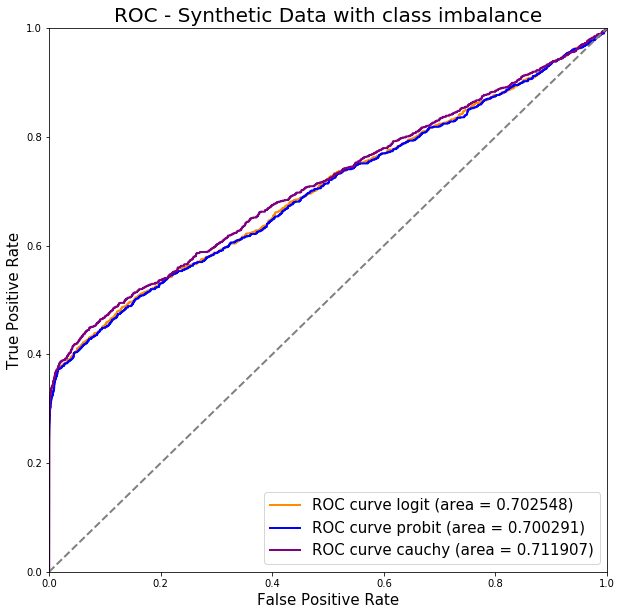

In [27]:
plot_roc(y_test = y_test, title = 'ROC - Synthetic Data with class imbalance', color = ['darkorange','blue','purple'],
         models = estimate(linkf = ['logit','probit','cauchy'])[1], 
         model_names = estimate(linkf = ['logit','probit','cauchy'])[2])

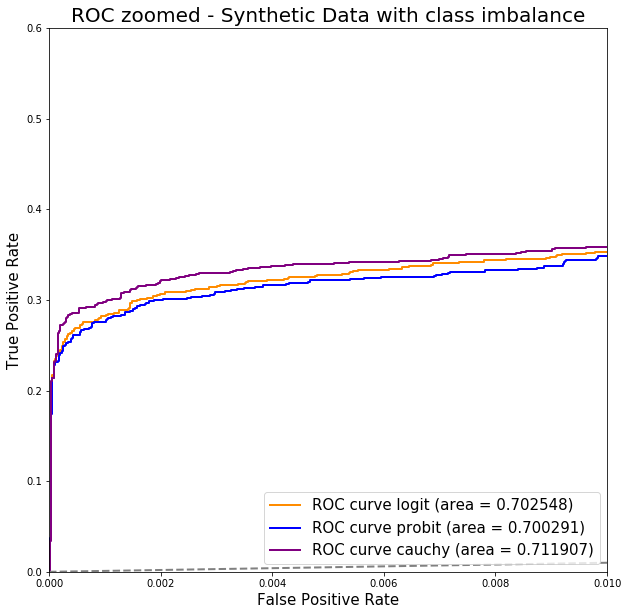

In [28]:
plot_roc(y_test = y_test, title = 'ROC zoomed - Synthetic Data with class imbalance', color = ['darkorange','blue','purple'],
         models = estimate(linkf = ['logit','probit','cauchy'])[1], 
         model_names = estimate(linkf = ['logit','probit','cauchy'])[2],
         zoomx= 0.01, zoom_x= 0, zoom_y = 0.6 ,zoomy = 0)

### Key takeaways

- All curves become tilted towards the class we have more observations of
- Cauchy is better in handling class imabalance than probit and logit. This is when the fat tails of the cauchy distribution pay off. With class imbalance, decisions at the boundary of the feature space become more important, because towards the mean we are less likely to make correct predictions, given the class imbalance. The cauchy cdf allocates more probability to these tail end events, and so reaps the reward if these are the events we feel safer with.

# 3. Conclusions

- The link function can have the effect of regularising the mean of the linear combination of features - it can either place higher or lower proability on events further away from the mean linear combination of feature.
- The logit link has natural appeal for binary problems because of its interpretation and the fact that it arises naturally/ is the canonical link for the bernoulli distribution.
- Yet, other link functions have parameters that allow us to fit the link to the problem at hand.
- We have seen this for cauchy, which has fatter tails and is thus better in handling class imbalance, but predicts less well around the mean. 
- It would be interesting to study in which situations it makes sense to try and tune the hyperparameters of the link functions.
- Computational aspects also matter - in my own attempt (see Appendix) I was not able to get an algorithm that converges for the breast cancer set for all link functions, only for the logit case. Very likely, these issues can be fixed, but given that the predictive performance differs only slighly, it would be worth it to properly consider computational costs.
- These considerations may not matter for a simple classification problem, given that the model performance was nearly identical throughout, but may be of importance in other contexts such as machine learning algorithms that rely heavily on link functions.
- With more time, further behaviour with regards to outliers could be explored, given that the response was more muted than I expected.

# Appendix

## My first attempt at implementing logistic regression using Newton Raphson

Uncomment the second last cell for a trial run. It seems to work fine for logit, albeit slow on large datasets, but not very well for the rest. For probit it jumps around between two values. I didn't have the time to look into it in more depth, but my guess would be that the matrix inversion does not work properly when it relies on non-canonical link functions.

In [29]:
# Estimation function

class BinaryRegression:
    # initiator method
    def __init__(self, steps=0.0001, max_iter=100000, fit_intercept=True, verbose=False, link='logit', approach = 'NR', precision = 15):
        self.lr = steps
        self.num_iter = max_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.link = link
        self.approach = approach
        self.precision = precision
    
    # method that adds intercept to design matrix
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    # method that picks the link function based on the instance var 'link'
    def __link(self, z, link):
        if self.link == 'logit':
            return 1 / (1 + np.exp(-z))
        elif self.link == 'probit':
            return scipy.special.ndtr(z)
        elif self.link == 'loglog':
            return 1 - np.exp(- np.exp(z))
        elif self.link == 'linear':
            return z + 1e-10 # can improve this with an if condition
    
    # method that runs the optimisation
    def fit(self, X, y):
        
        # add intercept if required
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # initialise beta with mean of features
        self.beta = np.zeros(X.shape[1])
        
        count = 0
        
        # loop over optimisation
        for i in range(self.num_iter):
            
            count += 1
            
            # initialise the linear combination of features
            z = X @ self.beta
            
            # apply the inverse of the link function to the linear combination of features
            g_inv = self.__link(z, self.link)
            
            # calculate the gradient at the current point
            gradient = X.T @ (g_inv - y)
                                  
            if (np.round(np.sum(gradient), self.precision) == 0):
                break
            
            if (self.approach == 'NR'):
                # calculate the Hessian at the current point
                inv_hessian = np.linalg.inv(X.T @ np.diag(g_inv *(1 - g_inv)) @ X)

                # adjust the parameter estimate using the gradient
                self.beta = self.beta - inv_hessian @ gradient
                
            elif (self.approach == 'GD'):
                self.beta = self.beta  - self.lr * gradient
            
            # re-calculate the linear combination of features
            z = X @ self.beta
            g_inv = self.__link(z, self.link)
            
            # likelihood
            if(self.verbose == True):
                likelihood = ((y.T @ X @ self.beta - np.sum(np.log(1 + np.exp(X @ self.beta)))) / y.shape)[0]
                print('Likelihood: ', likelihood,'Sum of Gradient: ', np.round(np.sum(gradient),self.precision), 'Iterations: ' , count, 'gradient1: ', gradient[1], 'beta1: ', self.beta[1])
        
        likelihood = ((y.T @ X @ self.beta - np.sum(np.log(1 + np.exp(X @ self.beta)))) / y.shape)[0]
        print('Likelihood: ', likelihood)
        print('Sum of Gradient: ', np.round(np.sum(gradient),self.precision))
        print('Iterations: ' , count)
        print('gradient1: ', gradient[1])                 
        print('beta1: ', self.beta[1])                       
                                      
    # method to predict probability of class
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__link(X @ self.beta, self.link)
    
    # method to assign class based on probability predicted
    def predict(self, X):
        return self.predict_prob(X).round()

In [30]:
model_logit = BinaryRegression(max_iter=50000, link='logit', verbose=False, approach='NR', precision = 10)
%time model_logit.fit(X_train, y_train)

Likelihood:  -0.07748588405793012
Sum of Gradient:  -0.0
Iterations:  10
gradient1:  -1.7763568394002505e-15
beta1:  0.16547519070469524
CPU times: user 3min 49s, sys: 2min 47s, total: 6min 36s
Wall time: 1min 56s


In [31]:
#model_probit = BinaryRegression(max_iter=50000, link='probit', verbose=False, approach='NR', precision = 10)
#%time model_probit.fit(X_train, y_train)